In [ ]:
!pip install -q -U albumentations

In [ ]:
!pip install dash

# Install above imports and Gdrive auth


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab.patches import cv2_imshow
import sys
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

import glob
import pathlib
from tqdm import tqdm
import re
import os
import shutil
import random
#Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import dash
# from dash import dcc, html
# from dash.dependencies import Input, Output
from matplotlib import pyplot as plt
import cv2
import seaborn as sns


import numpy as np
import pandas as pd
from math import sqrt
from google.colab.patches import cv2_imshow
#import splitfolders

# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

#Augmentations
import albumentations as A

# Unique IDS
import uuid

%matplotlib inline


start_data = '/content/drive/MyDrive/ColabNotebooks/Datas/plantvillage-dataset/color/'
base_path=None
'''35'''
BATCH_SIZE = 35

IMG_SIZE = 448

# Parsing of the path and creating the DataFrame


*   Fuction ***extract_plant_names*** seperates the Folder string names      into 2 new Series based on a **regex** pattern:

  *   Plants
  *   Sudirectory Names: Disease or Healty

*   Dictionary that retrives the orignal *strings* and *path files*
*   DataFrame that includes:

  *   Original Folder names
  *   File distribution of each folder ( Int )
  *   Plant Name
  *   Sudirectory Names
  *   Category based on a value


  







The prase of the starting location `root` can be one almsot 1 liner

```
# for files - files = [f for f in pathlib.Path().iterdir() if f.is_file()]
# for folders - files = [f for f in pathlib.Path().iterdir() if f.is_dir()]
```




In [ ]:
def extract_plant_names(folder_names, pattern):
    """
    Extract plant names from folder names using a regex pattern.
    Alerts for any unmatched folder names.

    Parameters:
        folder_names (list): List of folder names to process.
        pattern (str): Regex pattern to extract plant names.

    Returns:
        plant_names (list): List of extracted plant names.
        sub_names (list): List of the folder names with out the plant string.
    """
    plant_names = []
    unmatched = []
    sd_names = []

    for folder in folder_names:
        match = re.match(pattern, folder)
        if match:
            plant_name = match.group(1)
            sd_name = folder.split("___")[1]  # Assuming "___" separates the plant and the second name
            plant_names.append(plant_name)
            sd_names.append(sd_name)
        else:
            plant_names.append("Unknown")
            sd_names.append("Unknown")
            unmatched.append(plant_names)

    # Alert for unmatched folder names
    if unmatched:
        print("⚠️ Alert: The following folder names did not match the expected pattern:")
        for folder in unmatched:
            print(f"- {folder}")

    return plant_names,sd_names

In [ ]:

# def list_files_in_directory(directory, extensions=None):
#     """
#     Lists file paths in a directory, optionally filtering by extensions.

#     Returns:
#         tuple: (folder_name, list_of_files)
#     """
#     files = (f.path for f in os.scandir(directory.path) if f.is_file())

#     # Apply extension filter if provided
#     if extensions:
#         files = (f for f in files if f.endswith(extensions))

#     return directory.name, list(files)

# def parse_directory(start_data, extensions=None):
#     """
#     Parses directories and lists files in each folder sequentially.

#     Parameters:
#         start_data (str or Path): Root directory to scan.
#         extensions (tuple, optional): File extensions to filter (e.g., ('.txt', '.csv')).

#     Returns:
#         dict: {Folder Name -> List of File Paths}
#     """
#     root = pathlib.Path(start_data)
#     dirs = [entry for entry in os.scandir(root) if entry.is_dir()]

#     results = {
#         folder_name: files
#         for folder_name, files in tqdm(
#             (list_files_in_directory(directory, extensions) for directory in dirs),
#             desc="Processing Folders", unit="folder", total=len(dirs)
#         )
#     }
#     return results

# dist_files = parse_directory(start_data, extensions=('.jpg', '.png'))
# # Count files in each folder
# folder_counts = pd.DataFrame({'Folder': dist_files.keys(), 'Counts': [len(v) for v in dist_files.values()]})

# # Extract plant names
# pattern = r'^([^_]+)'

# folder_counts['Plants'] ,folder_counts['Sub']= extract_plant_names(folder_counts['Folder'], pattern)

In [ ]:
def classify_folders(counts):
    """
    Categorizes numerical counts into:
      - 'Above_mean' (counts => mean)
      - 'Below_mean' (half_mean ≤ counts ≤ mean)
      - 'Risk' (counts < half_mean)

    Returns a NumPy array of category labels.
    """
    mean_value = int(counts.mean())
    half_mean = mean_value // 2  # Ensure integer division consistency


    print(f"Mean: {mean_value}, Half Mean: {half_mean}")

    return np.select(
        [counts >= mean_value, counts >= half_mean],
        ["Above_mean", "Below_mean"],
        default="Risk"
    )

folder_counts["MeanCategory"] = classify_folders(folder_counts["Counts"])
folder_counts.head(5)

Mean: 1212, Half Mean: 606


,Folder,Counts,Plants,Sub,MeanCategory
0,Cherry_(including_sour)___Powdery_mildew,1052,Cherry,Powdery_mildew,Below_mean
1,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513,Corn,Cercospora_leaf_spot Gray_leaf_spot,Risk
2,Corn_(maize)___Common_rust_,1192,Corn,Common_rust_,Below_mean
3,Corn_(maize)___Northern_Leaf_Blight,985,Corn,Northern_Leaf_Blight,Below_mean
4,Corn_(maize)___healthy,1162,Corn,healthy,Below_mean


In [ ]:
p = pathlib.Path(start_data)
dist_files = {
    folder.name: [file for file in folder.iterdir()]
    for folder in p.iterdir() if folder.is_dir()
}

# Create DataFrame
# df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dist_files.items()]))
# df = df.reset_index(drop=True)

# Count files in each folder
folder_counts = pd.DataFrame({'Folder': dist_files.keys(), 'Counts': [len(v) for v in dist_files.values()]})

# Extract plant names
pattern = r'^([^_]+)'
folder_counts['Plants'] ,folder_counts['Sub']= extract_plant_names(folder_counts['Folder'], pattern)

In [ ]:
# print(folder_counts.info(),"",folder_counts.describe())
# print(folder_counts.head(3))


In [ ]:
remove=['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus',
        'Apple___Cedar_Rust','Tomato___Tomato_mosaic_virus','Potato___Early_blight','Potato___Late_blight','Potato___healthy']

# fldoer_counts = folder_counts.drop(columns=[key for key in remove if key in folder_counts])
final=folder_counts.drop(folder_counts[folder_counts['Folder'].isin(remove)].index)
final.reset_index(drop=True, inplace=True)

print(final.info(),"",final.describe())
print(final.head(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Folder        26 non-null     object
 1   Counts        26 non-null     int64 
 2   Plants        26 non-null     object
 3   Sub           26 non-null     object
 4   MeanCategory  26 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.1+ KB
None              Counts
count    26.000000
mean   1205.000000
std     509.894499
min     360.000000
25%     960.250000
50%    1135.500000
75%    1562.750000
max    2297.000000
                                     Folder  Counts  Plants  \
0  Cherry_(including_sour)___Powdery_mildew    1052  Cherry   
1               Corn_(maize)___Common_rust_    1192    Corn   
2       Corn_(maize)___Northern_Leaf_Blight     985    Corn   

                    Sub MeanCategory  
0        Powdery_mildew   Below_mean  
1          Common_rust_   Below_mean  
2  Nort

In [ ]:
mean_value = int(final["Counts"].mean())

# Anything that is" not in Risk will have 100 items the rest will be 200 items for validation and test
final["split_size"] = np.where(final["MeanCategory"] != "Risk", 200, 100)

# Compute the number of images available for training after the split
final["train_files"] = final["Counts"] - (final["split_size"]*2)
# we cut down the Above_mean category
final.loc[final["MeanCategory"] == "Above_mean", "train_files"] = mean_value // 2

# Compute the number of images that we need to compensate with augmentation
final["Augment_Needed"] = np.maximum(0, mean_value - final["train_files"])

# Compute the number of distinct images required for augmentation (rounded up)
final["original_files"] = np.ceil(final["Augment_Needed"] / 15).astype(int)

# FIxing the dataset imbalance

At first we have an over view of the description and info of our final dataset.

* We split the dataset based on the previous metric columns and we prepare the 4 dictionaries that hold as key,value pairs the **Folder Names** and the corresponding **image paths** .

* We create the folder structure that we want and populate the folders by copying or moving the image files. Those responsible of augmentation are fed to our function and create new augmented images **(15 x per img)+1 the original**.


---

For example:

The Final Amount that we want to achieve :  **31330**   
Amount of the original files for Augmentation: 1154         
Amount after the split and before Augmentation :  **14269**        
Amount of images we need to compasate with Augmentation : **17061**


---
Train size: **20376**  
Augmented:  **1154**   
Validation & Test:  **4900 x 2**

---





In [ ]:
p=r"/content/drive/MyDrive/ColabNotebooks/Final_thesis_code/data_stats.csv"
final.to_csv(p)

In [ ]:
# Create stats of the dataset
print(final.info(),"",final.describe())
print(final.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Folder          26 non-null     object
 1   Counts          26 non-null     int64 
 2   Plants          26 non-null     object
 3   Sub             26 non-null     object
 4   MeanCategory    26 non-null     object
 5   split_size      26 non-null     int64 
 6   train_files     26 non-null     int64 
 7   Augment_Needed  26 non-null     int64 
 8   original_files  26 non-null     int64 
dtypes: int64(5), object(4)
memory usage: 2.0+ KB
None              Counts  split_size  train_files  Augment_Needed  original_files
count    26.000000   26.000000    26.000000       26.000000       26.000000
mean   1205.000000  188.461538   548.807692      656.192308       44.384615
std     509.894499   32.581259   179.580850      179.580850       11.886385
min     360.000000  100.000000   160.000000      413.0

In [ ]:
print("The total Amount of all files files :  ",(final["Augment_Needed"] + final["train_files"]).sum(),"Amount that have reached the value ")
print("Amount of the original files for Augmentation:",final.original_files.sum())

print("Amount after the split of train and test and before Augmentation : ",final.train_files.sum())
print("Amount of images we need to compasate with Augmentation :",final.Augment_Needed.sum())

The total Amount of all files files :   31330 Amount that have reached the value 
Amount of the original files for Augmentation: 1154
Amount after the split of train and test and before Augmentation :  14269
Amount of images we need to compasate with Augmentation : 17061


In [ ]:
# Define storage lists
# train, train_label = [], []
# validation, val_label = [], []
# test, test_label = [], []
# aug_train, aug_label = [], []

train, validation, test, aug_train = {}, {}, {}, {}

# Function to distribute images efficiently
def distribute_images(folder_name, file_list, split_size, distinct_aug_sources):
    """
    Efficiently distributes images into train, validation, and test sets.
    Uses precomputed augmentation values and minimizes memory overhead.
    """
    random.shuffle(file_list)  # Shuffle to ensure randomness

    # Allocate test and validation sets based on split_size
    test[folder_name], file_list = file_list[:split_size], file_list[split_size:]

    validation[folder_name], file_list = file_list[:split_size], file_list[split_size:]


    # Reserving original images for augmentation
    aug_train[folder_name], file_list = file_list[:distinct_aug_sources], file_list[distinct_aug_sources:]

    # the remaining amount of the file list
    train[folder_name]=file_list


# Process each folder using precomputed values from folder_counts
for _, row in final.iterrows():
    folder = row["Folder"]
    available_files = dist_files.get(folder, [])

    # Extract necessary values
    split_size = row["split_size"]  # Now dynamically assigned per category
    distinct_aug_sources = int(row["original_files"])  # Available distinct images
    # For each key : Folder Name
    distribute_images(folder, available_files, split_size, distinct_aug_sources)

print(f"Train size: {len(train)} and {sum(len(v) for v in train.values())}")
print(f"Augmented: {len(aug_train)} and {sum(len(v) for v in aug_train.values())}")
print(f"Validation size: {len(validation)} and {sum(len(v) for v in validation.values())}")
print(f"Test size: {len(test)} and {sum(len(v) for v in test.values())}")


Train size: 26 and 20376
Augmented: 26 and 1154
Validation size: 26 and 4900
Test size: 26 and 4900


In [ ]:
for k,v in aug_train.items():
  print(k,len(v))

Cherry_(including_sour)___Powdery_mildew 37
Corn_(maize)___Common_rust_ 28
Corn_(maize)___Northern_Leaf_Blight 42
Corn_(maize)___healthy 30
Grape___Black_rot 29
Grape___Esca_(Black_Measles) 41
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 36
Grape___healthy 66
Peach___Bacterial_spot 41
Peach___healthy 70
Pepper,_bell___Bacterial_spot 41
Pepper,_bell___healthy 41
Strawberry___Leaf_scorch 34
Strawberry___healthy 64
Tomato___Bacterial_spot 41
Tomato___Early_blight 41
Tomato___Late_blight 41
Tomato___Leaf_Mold 44
Tomato___Septoria_leaf_spot 41
Tomato___Spider_mites Two-spotted_spider_mite 41
Tomato___Target_Spot 41
Tomato___healthy 41
Apple___Apple_Scab 65
Apple___Black_Rot 66
Apple___Healthy 41
Cherry_(including_sour)___Healthy 51


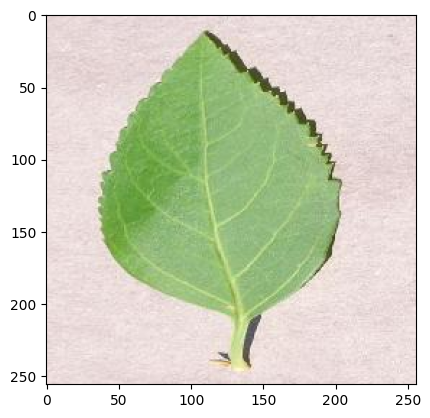

In [ ]:
aug_train.items()
for k,v in aug_train.items():
  a=cv2.imread(v[14],cv2.IMREAD_COLOR_RGB)
  plt.imshow(a)


In [ ]:
weather = A.Compose([
     A.RandomSnow(brightness_coeff=1.7,  snow_point_range= (0.3,0.5),p=0.5),
     A.RandomRain(brightness_coefficient=0.8, drop_width=2, blur_value=3, p=0.5)
 ])

light = A.Compose([
    # A. RandomBrightnessContrast(brightness_limit=(-0.23,0.35),p=0.5),
    A.GridDropout(ratio=0.3,p=0.5),
    A.MultiplicativeNoise(multiplier=(0.97,2.30),elementwise=True,per_channel=True,p=0.5)
])

geometric = A.Compose([
     A.CLAHE(p=1),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5)

])

def Augs(img):
  img=cv2.imread(img, cv2.IMREAD_COLOR_RGB)
  aug_img_list=[]
  aug_img_list.append(img)
  sshape=img.shape

  for _ in range(5):
    w=weather(image=img)['image']
    l=light(image=img)['image']
    g=geometric(image=img)['image']
    for i in [w,l,g]:
      if i.shape != sshape: i.reshape(sshape)
      aug_img_list.append(i)
  return aug_img_list

# def g_u(length):
#     return uuid.uuid4().hex[:length]
# d=r'/content/check/'
# for folder_name, image_paths in aug_train.items():
#     folder_path = os.path.join(d, folder_name)
#     os.makedirs(folder_path, exist_ok=True)

#     for image_path in image_paths:
#         aug_list = Augs(image_path)  # Apply augmentation

#         for aug_img in aug_list:
#           filename = os.path.join(folder_path, f"{uuid.uuid4().hex[:10]}.jpg")
#           cv2.imwrite(filename, aug_img)

In [ ]:
def process_images(dataset_dict, base_path, dataset_type, augment=None):
    for folder_name, image_paths in dataset_dict.items():
      # Take each folder_name and check if we have a folder
      folder_path = os.path.join(base_path, dataset_type, folder_name)
      os.makedirs(folder_path, exist_ok=True)
      # Take any image path of each folder_name and copy paste
      for image_path in image_paths:
          dest_path = os.path.join(folder_path, os.path.basename(image_path))
          shutil.copy(image_path, dest_path)

    if augment is not None:
      for k,v in augment.items():
        folder_path = os.path.join(base_path, dataset_type, k)
        for img_path in v:
          aug_list = Augs(img_path)
          for aug_img in aug_list:
              filename = os.path.join(folder_path, f"{uuid.uuid4().hex[:10]}.jpg")
              cv2.imwrite(filename, aug_img)
process_images(train, base_path, "train", augment=aug_train)
process_images(validation, base_path, "validation")
process_images(test, base_path, "test")

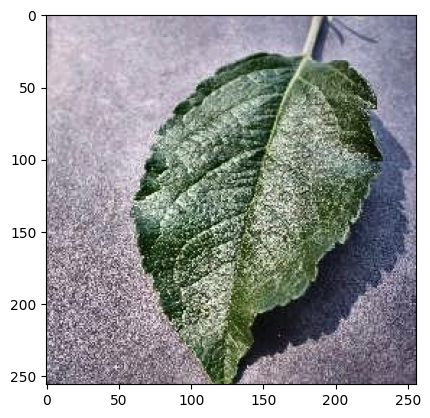

In [ ]:
check=r"/content/check"
p = pathlib.Path(check)
temp_dict = {
    folder.name: [file for file in folder.iterdir()]
    for folder in p.iterdir() if folder.is_dir()
}
for k,v in temp_dict.items():
  plt.imshow(cv2.imread(v[0]))
# # Count files in each folder
# count_check = pd.DataFrame({'Folder': temp_dict.keys()}, {'Counts': [len(v) for v in temp_dict.values()]})
# # comparison_df = count_check.merge(final[["Folder", "Augment_Needed"]], on="Folder", how="outer")
# # comparison_df

# Graphs for the dataset

Visualize metrics that have been compiled and answer the below questions.

**Nature of our data**

1.   How many Plant species do we have?
2.   How many categories for each Plant?
3.   How many files for each category and Plant?

---

1.   How many are Above, Below the mean value or At Risk?

> At risk is anything that is below half of the mean

2.   How many files do i need to compasate with Augmentation to reach the amount for each folder?








In [ ]:
def plot_file_distribution(df):
    """
    Creates a Plotly visualization with
      1* a Bar chart to show case the files before the split,
      2* Scatter plot that has (x) as points of the files after the split,
      3* Wave effect with the volume of images in need to reach the value with augmentation.

    of file distribution across categories,
    grouped by plant names with trend lines and wave effects for MeanCategory.

    Parameters:
        df (pd.DataFrame): DataFrame with columns
        [
        'Counts' --> files before the split, 'Plants',
        'MeanCategory' --> Category based on value *this case the mean value*,
        "train_files" --> files after the split].
        "Augmented_Needed" --> compasation with augmened images to reach the value
        "original_files" --> original images that used for augmentation ]
    Returns:
        None (displays the interactive Plotly figure)
    """

    # Compute mean and half-mean
    mean_count = int(df["Counts"].mean())
    # Sort DataFrame by Plant Name
    df_sorted = df.sort_values(by="Plants")

    # Create base bar chart for Original Counts (Grouped by Plant)
    fig = px.bar(df_sorted,
                 x="Folder",
                 y="Counts",
                 color="Plants",
                 title=f"File Distribution Across Folders (Grouped by Plant)<br>Mean: {mean_count}, Half of Mean: {mean_count/2}",
                 labels={"Folder": "Disease", "Counts": "File Count"}
                 )

    # Define colors for each MeanCategory
    category_colors = {"Risk": "red", "Above_mean": "blue", "Below_mean": "green"}

    # Plot separate lines for each MeanCategory with wave effect
    for category, color in category_colors.items():
        subset = df_sorted[df_sorted["MeanCategory"] == category]

        fig.add_trace(go.Scatter(
            x=subset["Folder"],
            y=subset["train_files"],  # Using train_files to show remaining after split
            mode="lines+markers",
            marker=dict(size=10, symbol="x"),
            line=dict(color=color, width=3),
            hoverinfo="text",
            text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(df["Augment_Needed"], df["Plants"],df["Sub"])],
            name=f"{category} Trend"
        ))

    fig.add_trace(go.Scatter(
        x=df_sorted["Folder"],
        y=df_sorted["Augment_Needed"],
        fill="tozeroy",  # Fill area under the line
        mode="lines",  # Keep the outline of the fill
        line=dict(width=1),  # No line on top of fill
        fillcolor="rgba(0, 100, 255, 0.3)",  # Light blue transparent fillhoverinfo="text",
        text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(df_sorted["Augment_Needed"], df_sorted["Plants"],df_sorted["Sub"])],
        name="Augmentation Wave",
        visible="legendonly"))

    # Update Layout for Readability
    fig.update_layout(
        xaxis_tickangle=-45,
        xaxis=dict(
            tickmode="array",
            tickvals=list(range(len(df_sorted["Folder"]))),
            ticktext=df_sorted["Sub"]
        ),
        showlegend=True,
        title_x=0.5,
        height=700,
        width=1200,
        barmode="overlay",
    )

    # Show figure
    fig.show()
plot_file_distribution(final)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

folder_counts_sorted = folder_counts.sort_values(by="Plants")

# Create base bar chart for Original Counts
fig = px.bar(folder_counts_sorted,
             x="Folder",
             y="Counts",
             color="Plants",
             title="Original Counts with Mean Category Trends & Wave Effect",
             labels={"Counts": "Number of Images", "Folder": "Category"},
             )

# Plot separate lines and wave effects for each MeanCategory (dynamically)
for category in folder_counts_sorted["MeanCategory"].unique():
    # Line + Markers
    fig.add_trace(go.Scatter(
        x=folder_counts_sorted.loc[folder_counts_sorted["MeanCategory"] == category, "Folder"],
        y=folder_counts_sorted.loc[folder_counts_sorted["MeanCategory"] == category, "Counts"],
        mode="lines+markers",
        marker=dict(size=10, symbol="x"),
        line=dict(width=3),
        # fill="tozeroy",

        name=f"{category} Trend"
    ))

fig.update_layout(
    xaxis_tickangle=-45,
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(len(folder_counts_sorted["Folder"]))),
        ticktext=folder_counts_sorted["Sub"]
    ),
    showlegend=True,
    title_text="Plant Disease Visualization Before the Fix",
    title_x=0.5,
    height=700,
    width=1200,
    barmode="overlay"
)

# Show figure
fig.show()


In [ ]:
def plot_file_aug(df):
  '''
  Creates a Plotly visualization of
    1* Bar chart with the Original files after the split.
    2* Scatter plot that has (x) and wave effect to showcase the amount of images
        through augmentation that we need to compasate
    3* Scatter plot with bold line to show case how many original images have been used for the augmentation.
  '''
  folder_counts_sorted = df.sort_values(by="Plants")
# Create base bar chart for Original Counts
  fig = px.bar(folder_counts_sorted,
              x="Folder",
              y="train_files",
              color="Plants",
              title="Original Counts and Augmentation Needed (Sorted by Plant)",
              labels={"Counts": "Number of Images", "Folder": "Category"})

  # Add Continuous Line Plot for Augmentation Needed
  fig.add_trace(go.Scatter(
    x=folder_counts_sorted["Folder"],
    y=folder_counts_sorted["Augment_Needed"],
    mode="lines+markers",
    marker=dict(size=10, color="black", symbol="x"),
    line=dict(color="blue", width=3),  # Continuous line connecting all points
    hoverinfo="text",
    text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(folder_counts_sorted["Augment_Needed"], folder_counts_sorted["Plants"],folder_counts_sorted["Sub"])],
    name="Augmentation Needed"
  ))

  # Add a filled area below the line for wave effect
  fig.add_trace(go.Scatter(
    x=folder_counts_sorted["Folder"],
    y=folder_counts_sorted["Augment_Needed"],
    fill="tozeroy",  # Fill area under the line
    mode="lines",  # Keep the outline of the fill
    line=dict(width=0),  # No line on top of fill
    hoverinfo="text",
    text=[f"Files to reach the value: {tf}<br>Plant: {p}<br>Sub: {s}" for tf, p, s in zip(folder_counts_sorted["Augment_Needed"], folder_counts_sorted["Plants"],folder_counts_sorted["Sub"])],
    fillcolor="rgba(0, 100, 255, 0.3)",  # Light blue transparent fill
    name="Augmentation Needed"
  ))

  fig.add_trace(go.Scatter(
    x=folder_counts_sorted["Folder"],
    y=folder_counts_sorted["original_files"],
    fill="tozeroy",  # Fill area under the line
    mode="lines",  # Keep the outline of the fill
    line=dict(width=3),  # No line on top of fill
    fillcolor="rgba(250, 165, 0, 0.5)",  # Light blue transparent fill
    name="Original Images used"
  ))

  # Update Layout for Readability
  fig.update_layout(
    xaxis_tickangle=-45,
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(len(folder_counts_sorted["Folder"]))),
        ticktext=folder_counts_sorted["Sub"]
    ),
    showlegend=True,
    title_text="Augmentation in need with dataset after the split",
    title_x=0.5,
    height=700,
    width=1200,
    barmode="overlay"
  )
  # Show figure
  fig.show()
plot_file_aug(final)

In [ ]:
category_distribution = final.groupby("MeanCategory")["Folder"].count()

# Group data for second pie chart (counting the number of sub-categories per plant)
plant_sub_distribution = final.groupby("Plants")["Sub"].nunique()

# Create a single dictionary to store hover texts for both pie charts
hover_texts_dict = {}

# Populate hover text for the first pie chart (Category Distribution)
for category in category_distribution.index:
    category_df = final[final["MeanCategory"] == category]
    plant_counts = category_df.groupby("Plants")["Folder"].nunique()
    plant_info = "<br>".join([f"{plant}: {count}" for plant, count in plant_counts.items()])

    hover_texts_dict[category] = (
        f"Files: {category_df['Counts'].sum()}<br>"
        f"Classes:<br>{plant_info}"
    )

# Populate hover text for the second pie chart (Plant-wise Sub-Category Distribution)
for plant in plant_sub_distribution.index:
    plant_df = final[final["Plants"] == plant]
    sub_counts = plant_df.groupby("Sub")["Counts"].sum()
    sub_info = "<br>".join([f"{sub}: {count}" for sub, count in sub_counts.items()])

    hover_texts_dict[plant] = (
        f"Total Files: {plant_df['Counts'].sum()}<br>"
        f"Sub-Category Distribution:<br>{sub_info}"
    )

# Define custom colors for categories and plants
category_colors = {"Above_mean": "green", "Below_mean": "blue", "Risk": "red"}
plant_colors = {
    "Apple": "orange", "Cherry": "purple", "Corn": "yellow", "Grape": "green",
    "Peach": "pink", "Pepper,": "red", "Potato": "brown", "Strawberry": "magenta", "Tomato": "darkred"
}

# Create the figure with subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Category Distribution", "Plant-wise Sub-Category Distribution"),
    column_widths=[0.5, 0.5],  # Equal width for both pie charts
    specs=[[{"type": "pie"}, {"type": "pie"}]]  # Two pie charts
)

# Add Pie Chart 1: MeanCategory Distribution
fig.add_trace(go.Pie(
    labels=category_distribution.index,
    values=category_distribution.values,
    textinfo="label+value",
    hoverinfo="text",
    text=category_distribution.index,
    hovertext=[hover_texts_dict[cat] for cat in category_distribution.index],  # Using the single hover text dictionary
    marker=dict(colors=[category_colors[cat] for cat in category_distribution.index]),
    hole=0.4  # Donut-style chart
), row=1, col=1)

# Add Pie Chart 2: Plant-wise Sub-Category Distribution
fig.add_trace(go.Pie(
    labels=plant_sub_distribution.index,
    values=plant_sub_distribution.values,
    textinfo="label+value",
    hoverinfo="text",
    text=plant_sub_distribution.index,
    hovertext=[hover_texts_dict[plant] for plant in plant_sub_distribution.index],  # Using the same hover text dictionary
    marker=dict(colors=[plant_colors[plant] for plant in plant_sub_distribution.index]),
    hole=0.4  # Donut-style chart
), row=1, col=2)

# Update layout
fig.update_layout(
    title_text="Plant Disease Data Visualization",
    title_x=0.5,
    height=700,
    width=1200,
)

# Display the figure
fig.show()

In [ ]:
plant_counts = final.groupby('Plants')['train_files'].sum().reset_index()

# Create the pie chart
fig = px.pie(plant_counts,
             names='Plants',
             values='train_files',
             title='File Distribution by Plant')
fig.update_traces(
    textinfo='percent+label',
    texttemplate='%{label}: %{percent:.0%}',  # Rounds percentages to whole numbers
    hovertemplate=(
        "<b>%{label}</b><br>"
        "File Count: %{value}<br>"
        "Folder Count: %{customdata[0]}<br>"
        "Percentage: %{percent:.1%}"
    ))

fig.show()

In [ ]:



# Initialize Dash app
app = dash.Dash(__name__)

# Create the pie chart with consistent color scheme
fig_pie = px.pie(
    folder_counts,
    names='Plants',
    values='Counts',
    title="Folder Distribution by Plant",
    color='Plants',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Create the bar chart (which will be updated dynamically)
fig_bar = {
    'data': [],
    'layout': {
        'title': 'Folder Distribution for Plant',
        'xaxis': {'title': 'Folder'},
        'yaxis': {'title': 'File Counts'}
    }
}

# Define the layout of the app
app.layout = html.Div([
    html.H1("Dataset Distribution Dashboard"),

    # Container to hold both charts side by side
    html.Div([
        # Pie chart to show plant distribution
        html.Div([
            dcc.Graph(
                id='plant-pie-chart',
                figure=fig_pie
            )
        ], style={'width': '48%', 'display': 'inline-block'}),

        # Bar chart to show folder distribution (updates based on pie chart click)
        html.Div([
            dcc.Graph(
                id='folder-bar-chart',
                figure=fig_bar
            )
        ], style={'width': '48%', 'display': 'inline-block'})
    ], style={'display': 'flex', 'justify-content': 'space-between'})
])

# Define the callback to update the bar chart based on pie chart click
@app.callback(
    Output('folder-bar-chart', 'figure'),
    [Input('plant-pie-chart', 'clickData')]
)
def update_bar_chart(click_data):
    if click_data is None:
        # If no slice is clicked, return the empty bar chart
        return fig_bar

    # Get the plant name from the clicked slice
    plant_name = click_data['points'][0]['label']

    # Filter the folder data based on the selected plant
    plant_data = folder_counts[folder_counts['Plants'] == plant_name]

    # Create the bar chart with consistent color coding
    fig = {
        'data': [{
            'x': plant_data['Folder'],
            'y': plant_data['Counts'],
            'type': 'bar',
            'name': plant_name,
            'marker': {'color': px.colors.qualitative.Set2[0]}  # Keep color consistent for the plant
        }],
        'layout': {
            'title': f"Folder Distribution for {plant_name}",
            'xaxis': {'title': 'Folder'},
            'yaxis': {'title': 'File Counts'}
        }
    }

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


# Below are old

In [ ]:
mean_data = int(sum(stats.values())/len(stats)) #it should be 1154
risk=mean_data//2
print('Mean value of the sum data',mean_data)
print('Value that can oppose a risk to training',risk)

print('')

above_mean=[i for i in stats.keys() if stats[i]>mean_data]
print('Labels that their sum amount is Above the mean value :',len(above_mean))
for i in above_mean:
  print('',i, ':',stats[i])

print('')

below_mean=[i for i in stats.keys() if stats[i]<mean_data and stats[i]>=risk and stats[i]>=1000 ] # the 1000 should be ammount form the user

# we want to print any label below the amount that we choose
below_amount=[k for k,v in stats.items() if v < 1000 and v>=risk]


print('Labels that their sum amount is Below the mean value : ',len(below_mean))
for i in below_mean:
  print('',i, ':',stats[i])

print('')

print('Labels that are below 1000 : ',len(below_amount))
for i in below_amount:
  print('',i, ':',stats[i])

print('')
crit=[i for i in stats.keys() if stats[i]<=risk]

print('Labels that their sum amount is in critical level : ',len(crit))
for i in crit:
  print('',i, ':',stats[i])

Mean value of the sum data 1205
Value that can oppose a risk to training 602

Labels that their sum amount is Above the mean value : 10
 Grape___Esca_(Black_Measles) : 1383
 Peach___Bacterial_spot : 2297
 Pepper,_bell___healthy : 1478
 Tomato___Bacterial_spot : 2127
 Tomato___Late_blight : 1909
 Tomato___Septoria_leaf_spot : 1771
 Tomato___Spider_mites Two-spotted_spider_mite : 1676
 Tomato___Target_Spot : 1404
 Tomato___healthy : 1591
 Apple___Healthy : 1645

Labels that their sum amount is Below the mean value :  7
 Cherry_(including_sour)___Powdery_mildew : 1052
 Corn_(maize)___Common_rust_ : 1192
 Corn_(maize)___healthy : 1162
 Grape___Black_rot : 1180
 Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 1076
 Strawberry___Leaf_scorch : 1109
 Tomato___Early_blight : 1000

Labels that are below 1000 :  6
 Corn_(maize)___Northern_Leaf_Blight : 985
 Pepper,_bell___Bacterial_spot : 997
 Tomato___Leaf_Mold : 952
 Apple___Apple_Scab : 630
 Apple___Black_Rot : 621
 Cherry_(including_sour)___Heal

We have the **MEAN** value of the sum amount of the dataset **(Sum/labels)**
Based on that value *(mean)* we compute the labels that are **Above**, **Below** and **Critical** below of the mean so we can use different strategies.

The Augmentation function includes 3 types of augmentations *(weather, geometric,noise)* We *collect the original* image and we pass it through the 3 augmentation funcitons 5 times.

The **Output** will be 16 images 15 augmented and the original.

So (33*15)+33=528 && 528 +500 == 1028

->   **Above** --> Means that we have an excess amount of data in the label.In this example the mean is 1154 so the total training amount should be 1000-1200. The excess amount will go for test/validation subset.

* **Stradegy** --> Random 500 will be randomly selected of the pool of 1000-1200, plus 33 photos that will be used to fill the space until to reach 1200 max.

->   **Below** --> Includes Labels with amount lower than the mean value but no risk values *(mean/2)*.
Labels will include also values that may be lower than the amount that we chose to have for training.

*  **Stradegy** --> The Labels with amount equal or above the amount that we chose for training will be process like the category **Above** the rest we will hold some and the rest will be held for test/validation if they are not enough we will duplicate a part of them to cover the difference.

  **Example** == 621*0.40=248(int) and 621-248=372 this is the remain of test/validation (40%) so 1000-372=627 that we need to cover so 627/16=39.
  We need to augment only 39 random distinct images.

->  **Critical** --> Labels that are lower than the *risk* value


In [ ]:

'''
Will take a label (for in mean_amount)
If label - 400=D
k
X=Amount-D
'''
def find_ls_mean(x):
  sum=0
  for i in x:
    if i in stats.keys():
      sum+=stats[i]
  return sum/len(x)



def find_D_X(y):
  W=0
  if y in stats.keys():
    D=stats[y]-400
    W= 1000-int(D)
    W = W//16
    W+=1
  return W

In [ ]:
for i in crit:
  print(find_D_X(i))

62
66
60


In [ ]:
def find_D_X(y):
  W=0
  if y in stats.keys():
    D=stats[y]-400
    W= 1000-int(D)
    W = W//16
    W+=1
  return W

for i in dist_files.keys():
  if i in below_amount:
    aug_imgs=find_D_X(i)
# Copy the dict.values and shuffle them
    temp=dist_files[i].copy()
    random.shuffle(temp)
# Dummy list is just transfer loads!
    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      test.append(y)
      test_label.append(i)
#  Every time we transfer something to Dummy
#  we delete from temp and then we clear dummy
    dummy.clear()
    dummy= temp[0:aug_imgs]
    del temp[0:aug_imgs]

    for y in range(len(temp)):
      train.append(temp[y])
      train_label.append(i)

    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)
    dummy.clear()
    temp.clear()

In [ ]:
train=[]
train_label=[]
validation=[]
val_label=[]
test=[]
test_label=[]
temp=[]
dummy=[]
aug_train=[]
aug_label=[]
tv_amount=200

for i in dist_files.keys():
  if i in above_mean:
    #copy into a list
    temp=dist_files[i].copy()
    random.shuffle(temp)

    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      test.append(y)
      test_label.append(i)

    dummy.clear()
    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy=temp[0:33]
    del temp[0:33]

    for y in range(500):
      train.append(temp[y])
      train_label.append(i)
    del temp[0:500]


    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)

    dummy.clear()
    temp.clear()

  elif i in below_mean:
    temp=dist_files[i].copy()
    random.shuffle(temp)

    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      test.append(y)
      test_label.append(i)


    dummy.clear()
    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy=temp[0:33]
    del temp[0:33]

    for y in range(500):
      train.append(temp[y])
      train_label.append(i)

    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)
    dummy.clear()
    temp.clear()

  elif i in below_amount:
    aug_imgs=find_D_X(i)

    temp=dist_files[i].copy()
    random.shuffle(temp)

    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      test.append(y)
      test_label.append(i)


    dummy.clear()
    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy= temp[0:aug_imgs]
    del temp[0:aug_imgs]

    for y in range(len(temp)):
      train.append(temp[y])
      train_label.append(i)


    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)
    dummy.clear()
    temp.clear()

  elif i in crit:
    aug_imgs=find_D_X(i)

    temp=dist_files[i].copy()
    random.shuffle(temp)

    dummy=temp[0:100]
    del temp[0:100]

    for y in dummy:
      test.append(y)
      test_label.append(i)

    dummy.clear()
    dummy=temp[0:100]
    del temp[0:100]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy= temp[0:aug_imgs]
    del temp[0:aug_imgs]

    for y in range(len(temp)):
      train.append(temp[y])
      train_label.append(i)


    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)
    dummy.clear()
    temp.clear()

### Those are created because i copy paste files in random bu tonly for train

In [ ]:
# new train stats
dist_dump={}
for folder in os.listdir(dir_path):
  dist_dump[folder]=[os.path.join(dir_path + folder,file) for file in os.listdir(os.path.join(dir_path, folder))]

dump_stats = { k: len(v) for k, v in dist_dump.items() }
print(sum(dump_stats.values()))
dump_stats

27588


{'Cherry_(including_sour)___Powdery_mildew': 1028,
 'Corn_(maize)___Common_rust_': 1028,
 'Corn_(maize)___Northern_Leaf_Blight': 975,
 'Corn_(maize)___healthy': 1028,
 'Grape___Black_rot': 1028,
 'Grape___Esca_(Black_Measles)': 1028,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1028,
 'Grape___healthy': 1153,
 'Peach___Bacterial_spot': 1028,
 'Peach___healthy': 1150,
 'Pepper,_bell___Bacterial_spot': 987,
 'Pepper,_bell___healthy': 1028,
 'Strawberry___Leaf_scorch': 1056,
 'Strawberry___healthy': 1116,
 'Tomato___Bacterial_spot': 1056,
 'Tomato___Early_blight': 1056,
 'Tomato___Late_blight': 1056,
 'Tomato___Leaf_Mold': 951,
 'Tomato___Septoria_leaf_spot': 1056,
 'Tomato___Spider_mites Two-spotted_spider_mite': 1056,
 'Tomato___Target_Spot': 1056,
 'Tomato___healthy': 1056,
 'Apple___Apple_Scab': 1249,
 'Apple___Black_Rot': 1240,
 'Apple___Healthy': 1056,
 'Cherry_(including_sour)___Healthy': 1039}

In [ ]:
#  double check the new train with the old location we dont want the same files
oo={}
for i in dist_dump.keys():
  slow=[]
  temp=dist_dump[i].copy()
  temp1=dist_files[i].copy()
  for y in range(len(temp1)):
    txt1=temp1[y].split('/')
    temp1[y]=txt1[-1]
  for j in range(len(temp)):
    txt=temp[j].split('/')
    temp[j]=txt[-1]
  print(i,' : ', "dist_dump ",len(temp),  'original ', len(temp1))
  for k in range(len(temp1)):
    if temp1[k] not in temp:
      slow.append(temp1[k])
  print(len(slow))
  pp=os.path.join(start_data,i)
  oo[i]=[os.path.join(pp,l) for l in slow]


s = { k: len(v) for k, v in oo.items() }

print(sum(s.values()))
s

Cherry_(including_sour)___Powdery_mildew  :  dist_dump  500 original  1052
552
Corn_(maize)___Common_rust_  :  dist_dump  500 original  1192
692
Corn_(maize)___Northern_Leaf_Blight  :  dist_dump  559 original  985
426
Corn_(maize)___healthy  :  dist_dump  500 original  1162
662
Grape___Black_rot  :  dist_dump  500 original  1180
680
Grape___Esca_(Black_Measles)  :  dist_dump  500 original  1383
883
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)  :  dist_dump  500 original  1076
576
Grape___healthy  :  dist_dump  161 original  423
262
Peach___Bacterial_spot  :  dist_dump  500 original  2297
1797
Peach___healthy  :  dist_dump  94 original  360
266
Pepper,_bell___Bacterial_spot  :  dist_dump  571 original  997
426
Pepper,_bell___healthy  :  dist_dump  500 original  1478
978
Strawberry___Leaf_scorch  :  dist_dump  500 original  1109
609
Strawberry___healthy  :  dist_dump  196 original  456
260
Tomato___Bacterial_spot  :  dist_dump  500 original  2127
1627
Tomato___Early_blight  :  dist_dump  5

Counter({'Cherry_(including_sour)___Powdery_mildew': 33,
         'Corn_(maize)___Common_rust_': 33,
         'Corn_(maize)___Northern_Leaf_Blight': 26,
         'Corn_(maize)___healthy': 33,
         'Grape___Black_rot': 33,
         'Grape___Esca_(Black_Measles)': 33,
         'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 33,
         'Grape___healthy': 62,
         'Peach___Bacterial_spot': 33,
         'Peach___healthy': 66,
         'Pepper,_bell___Bacterial_spot': 26,
         'Pepper,_bell___healthy': 33,
         'Strawberry___Leaf_scorch': 33,
         'Strawberry___healthy': 60,
         'Tomato___Bacterial_spot': 33,
         'Tomato___Early_blight': 33,
         'Tomato___Late_blight': 33,
         'Tomato___Leaf_Mold': 29,
         'Tomato___Septoria_leaf_spot': 33,
         'Tomato___Spider_mites Two-spotted_spider_mite': 33,
         'Tomato___Target_Spot': 33,
         'Tomato___healthy': 33,
         'Apple___Apple_Scab': 49,
         'Apple___Black_Rot': 49,
         

In [ ]:
# take the amount of augment img for each label and create new list that save in check.csv
from collections import Counter
c=Counter(aug_label)
print(c)

validation=[]
val_label=[]
test=[]
test_label=[]
temp=[]
dummy=[]
aug_train=[]
aug_label=[]
tv_amount=200

for i in oo.keys():
  if i in above_mean:
    #copy into a list
    temp=oo[i].copy()
    random.shuffle(temp)

    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      test.append(y)
      test_label.append(i)

    dummy.clear()
    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy=temp[0:c[i]]
    del temp[0:c[i]]

    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)

    dummy.clear()
    temp.clear()

  elif i in below_mean:
    temp=oo[i].copy()
    random.shuffle(temp)

    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      test.append(y)
      test_label.append(i)


    dummy.clear()
    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy=temp[0:c[i]]
    del temp[0:c[i]]

    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)
    dummy.clear()
    temp.clear()

  elif i in below_amount:

    temp=oo[i].copy()
    random.shuffle(temp)

    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      test.append(y)
      test_label.append(i)


    dummy.clear()
    dummy=temp[0:tv_amount]
    del temp[0:tv_amount]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy= temp[0:c[i]]
    del temp[0:c[i]]

    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)
    dummy.clear()
    temp.clear()

  elif i in crit:

    temp=oo[i].copy()
    random.shuffle(temp)

    dummy=temp[0:100]
    del temp[0:100]

    for y in dummy:
      test.append(y)
      test_label.append(i)


    dummy.clear()
    dummy=temp[0:100]
    del temp[0:100]

    for y in dummy:
      validation.append(y)
      val_label.append(i)

    dummy.clear()
    dummy= temp[0:c[i]]
    del temp[0:c[i]]

    for l in dummy:
      aug_train.append(l)
      aug_label.append(i)
    dummy.clear()
    temp.clear()

In [ ]:
print(len(test),len(test_label))
print(len(validation),len(val_label))

4900 4900
4900 4900


In [ ]:
print(len(aug_train),len(aug_label))

963 963


In [ ]:
# # We created new directories with label names
# l=list(dist_files.keys())
# for i in l:
#   os.mkdir(os.path.join(oof, i))

In [ ]:
# function to move files
# for n,i in enumerate(val_label):
#   if i in ['Apple___Black_Rot']:
#     name=validation[n].split('/')
#     pp=os.path.join(v_path, i)
#     shutil.copyfile(validation[n], os.path.join(pp,name[-1]))

In [ ]:
for n,i in enumerate(val_label):
  if i in ['Apple___Black_Rot']:
    name=validation[n].split('/')
    if name not in w:
      pp=os.path.join(v_path, i)
      shutil.copyfile(validation[n], os.path.join(pp,name[-1]))

In [ ]:
# load the check.csv
import csv
rows = []
with open("/content/drive/MyDrive/ColabNotebooks/Datas/check.csv") as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)

In [ ]:
rows

[['Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___Powde

In [ ]:
# check hte unique names and the rows form csv
id=uuid.uuid4().hex[:10]
i='Cherry_(including_sour)___Powdery_mildew'
name=dir_path+i+'/'+id+'.jpg'
print(name)

print(row[0]," and  ",header[0])

/content/drive/MyDrive/ColabNotebooks/Datas/Plantvilage_that_we_will_use/Cherry_(including_sour)___Powdery_mildew/17584ed7b5.jpg
Cherry_(including_sour)___Powdery_mildew  and   /content/drive/MyDrive/ColabNotebooks/Datas/plantvillage-dataset/color/Cherry_(including_sour)___Powdery_mildew/6f76b1b9-8650-4510-bdb5-3f82191e6bc8___FREC_Pwd.M 4841.JPG


In [ ]:
why=['Strawberry___healthy','Strawberry___Leaf_scorch','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot','Tomato___healthy','Apple___Black_Rot','Apple___Apple_Scab','Apple___Healthy','Cherry_(including_sour)___Healthy']
len(why)

14

In [ ]:
# fuction that moves/delete excess items of why list labels
dek=[]

for i in dist_dump.keys():
  if i in why and dump_stats[i]>1600:
    if dump_stats[i]>1990:
      con=0
      print(i)
      temp=dist_dump[i].copy()
      random.shuffle(temp)
      for k in temp:
        name=k.split('/')
        if len(name[-1])<15:
          if con != 1000:
            con+=1
            pp=os.path.join(dir_path, i)
            dek.append(os.path.join(pp,k))
    else:
      con=0
      print(i)
      temp=dist_dump[i].copy()
      random.shuffle(temp)
      for k in temp:
        name=k.split('/')
        if len(name[-1])<15:
          if con != 500:
            con+=1
            pp=os.path.join(dir_path, i)
            dek.append(os.path.join(pp,k))
  elif i in why and dump_stats[i]>1400:
    con=0
    print(i)
    temp=dist_dump[i].copy()
    random.shuffle(temp)
    for k in temp:
      name=k.split('/')
      if len(name[-1])<15:
        if con != 500:
          con+=1
          pp=os.path.join(dir_path, i)
          dek.append(os.path.join(pp,k))






Strawberry___Leaf_scorch
Strawberry___healthy
Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___healthy
Apple___Apple_Scab
Apple___Black_Rot
Apple___Healthy
Cherry_(including_sour)___Healthy


In [ ]:
len(dek)
for i in dek:
  shutil.move(i, dele)

In [ ]:
# append all the new augment imgs to train folders
def Augs(img):
  img=cv2.imread(img,cv2.IMREAD_COLOR)
  aug_img_list=[]
  aug_img_list.append(img)
  sshape=img.shape

  for i in range(5):
    w=weather(image=img)['image']
    l=light(image=img)['image']
    g=geometric(image=img)['image']
    temp=[w,l,g]
    for i in temp:
      if i.shape != sshape: i.reshape(sshape)
      aug_img_list.append(i)
  return aug_img_list

def g_u(length):
    return uuid.uuid4().hex[:length]

aug_dist={}
for i in range(len(row)):
  au_list=Augs(header[i])
  for k in range(len(au_list)):
    name=os.path.join(dir_path,row[i],g_u(10)+'.jpg')
    cv2.imwrite(os.path.join(dir_path,row[i],g_u(10)+'.jpg'),cv2.cvtColor(au_list[k], cv2.COLOR_BGR2RGB))



NameError: name 'why' is not defined

In [ ]:
'''
Or we use the mean or an amount of the USER

If S>1000 keep the 500 and augment the rest to fit the FULL AMOUNT(MEAN OR USER AMOUNT)
take also 200-250 for val & test can be automatically.


An S=sunoliko of LABEL
   M= mean Of Total Amount/ OR /TO BE CHANGED BY USER
   N= Amount in % pososto pou tha paroume apo S / or user change mean gia allagh toy kai pososto bori na autopoih8i
   c= M * %N einai to poso pou prepei na paroume mia gia val mia gia test
   A= c*2
   D = S-A POSO LABEL AFTER SPLIT TEST
   X = M-D POSO APEXEI TO D NA FTASI TO M
   Omega=INT(X/16) +1 Einai to plhthos imgs pros -->
          -->AUG
                AUG(X)>=D && D+AUG(X)=M

   IF S >=M and D > X:  INT(X/16) +1 = temp for train imgs [TO 16 EINAI 16 UNSEEN IMGS]
IF S >= mean && S-A>=100: augment tosa


  Stats[i]= S
  mean_data= M
  20%= N or 200=c
  A=400
  D= Stats[i] - 400
  X= ((int(D - mean_data) // 16)+1


'''

In [ ]:
df_train=pd.DataFrame(columns=['imgs','labels'])
df_train['imgs']=train
df_train['labels']=train_label

df_test=pd.DataFrame(columns=['imgs','labels'])
df_test['imgs']=test
df_test['labels']=test_label

df_val=pd.DataFrame(columns=['imgs','labels'])
df_val['imgs']=validation
df_val['labels']=val_label

In [ ]:
df_train.to_csv('/content/drive/MyDrive/ColabNotebooks/Thesis_code/data.csv')

df_val.to_csv('/content/drive/MyDrive/ColabNotebooks/Thesis_code/val.csv')

df_test.to_csv('/content/drive/MyDrive/ColabNotebooks/Thesis_code/test.csv')



In [ ]:
print(len(train),len(train_label))
print(len(test),len(test_label))
print(len(validation),len(val_label))

31654 31654
5900 5900
5900 5900


In [ ]:
sh=[]
for i in range(6):
  for k in dist_files.keys():
    for j in range(1):
      sh.append(list(dist_files[k])[j])

In [ ]:
sh[0]

'/content/drive/MyDrive/ColabNotebooks/Datas/plantvillage-dataset/color/Cherry_(including_sour)___Powdery_mildew/0ab4bd76-19fb-4372-9ac0-9582843c4008___FREC_Pwd.M 0263.JPG'

In [ ]:
plt.subplots(2,3,figsize=(12, 12))

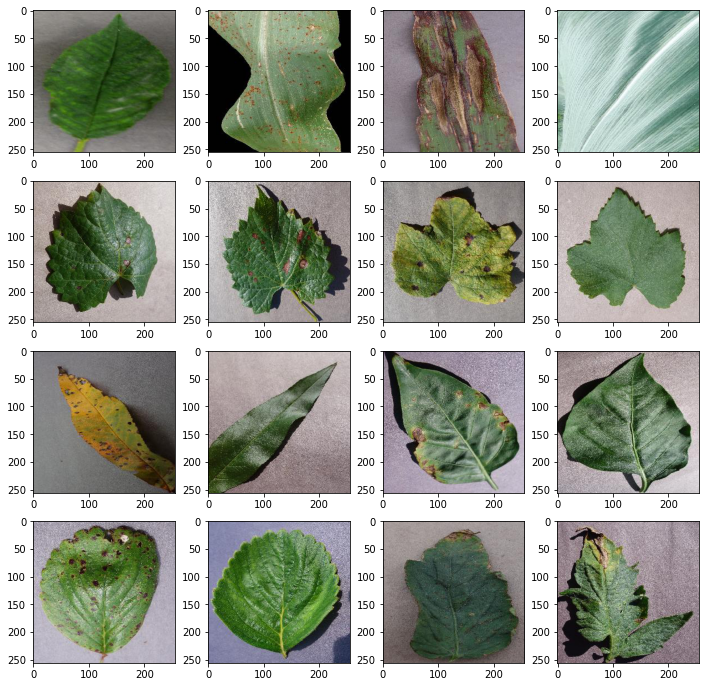

In [ ]:
col=4
row=4
_, axs = plt.subplots(row, col, figsize=(12, 12))
axs = axs.flatten()

for img, ax in zip(sh, axs):
  img=plt.imread(img)
  ax.imshow(img)
plt.show()

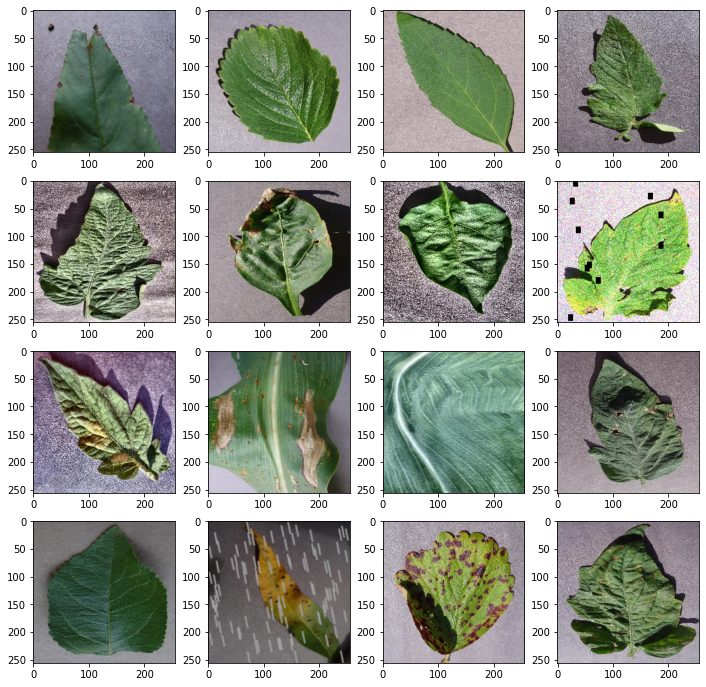

In [ ]:
col=4
row=4
_, axs = plt.subplots(row, col, figsize=(12, 12))
axs = axs.flatten()

for img, ax in zip(train, axs):
  ax.imshow(img)
plt.show()

# Exmple of visualizations as demos





In [ ]:
import plotly.graph_objects as go
mean_count = folder_counts["Counts"].mean()
half_mean = mean_count / 2
quarter_mean = mean_count / 4

# Categorize Folders into three groups for the scatter plot
above_mean = folder_counts[folder_counts["Counts"] > mean_count]
between_half_mean = folder_counts[(folder_counts["Counts"] <= mean_count) & (folder_counts["Counts"] > half_mean)]
below_quarter_mean = folder_counts[folder_counts["Counts"] <= quarter_mean]

# Create the bar chart
fig = px.bar(
    folder_counts,
    x="Folder",
    y="Counts",  # Keep Folder as the y-axis reference
    color="Plants",
    title="File Distribution Across Folders (Grouped by Plant) with Threshold Lines",
    labels={"Folder": "Folder Name", "Counts": "File Count"},
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Scatter plot line for Above Mean
fig.add_trace(go.Scatter(
    x=above_mean["Folder"],
    y=above_mean["Counts"],
    mode="lines+markers",
    line=dict(color="red", width=3),
    name="Above Mean"
))

# Scatter plot line for Between Half and Mean
fig.add_trace(go.Scatter(
    x=between_half_mean["Folder"],
    y=between_half_mean["Counts"],
    mode="lines+markers",
    line=dict(color="blue", width=3),
    name="Between Half Mean"
))

# Scatter plot line for Below Quarter Mean
fig.add_trace(go.Scatter(
    x=below_quarter_mean["Folder"],
    y=below_quarter_mean["Counts"],
    mode="lines+markers",
    line=dict(color="green", width=3),
    name="Below Quarter Mean"
))

# Update layout for better readability
fig.update_layout(
    xaxis_tickangle=-45,  # Rotate x-axis labels

    xaxis=dict(
        tickmode="array",
        tickvals=folder_counts["Folder"],  # Use original Folder names for positioning
        ticktext=folder_counts["Sub"]      # Display only 'Sub' column instead
    ),
    xaxis_title="File Counts",
    yaxis_title="Disease/Condition",
    showlegend=True,
    title_x=0.5,
    height=700,
    width=1200)
# Display the graph
fig.show()

In [ ]:
# Compute Mean Value
mean_value = folder_counts["Counts"].mean()

# Filter Folders Based on Mean
above_mean = folder_counts[folder_counts["Counts"] > mean_value]
below_mean = folder_counts[folder_counts["Counts"] <= mean_value]

# Create the bar chart
fig = px.bar(
    folder_counts,
    x="Counts",
    y="Folder",
    color="Plant",
    title="File Distribution Across Folders (Grouped by Plant)",
    labels={"Folder": "Folder Name", "Counts": "File Count"},
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Add Line Connecting Folders Above the Mean
fig.add_trace(
    go.Scatter(
        x=above_mean["Counts"],  # Counts of folders above the mean
        y=above_mean["Folder"],   # Folder names corresponding to above mean counts
        mode="lines+markers",     # Lines connecting points with markers
        name="Above Mean",
        line=dict(color="green", width=2),
        marker=dict(color="green", size=8, symbol="circle")
    )
)

# Add Line Connecting Folders Below the Mean
fig.add_trace(
    go.Scatter(
        x=below_mean["Counts"],  # Counts of folders below or equal to the mean
        y=below_mean["Folder"],  # Folder names corresponding to below mean counts
        mode="lines+markers",    # Lines connecting points with markers
        name="Below Mean",
        line=dict(color="orange", width=2),
        marker=dict(color="orange", size=8, symbol="circle")
    )
)

# Update Layout
fig.update_layout(
    xaxis_title="File Counts",
    yaxis_title="Folder Names",
    showlegend=True,
    title_x=0.5,
    height=600,
    width=1000
)

# Show the figure
fig.show()


In [ ]:


# Create the bar graph
fig = px.bar(
    folder_counts,
    x="Folder",
    y="Counts",
    color="Plants",
    title="File Distribution Across Folders (Grouped by Plant)",
    labels={"Folder": "Folder Name", "Counts": "File Count"},
    color_discrete_sequence=px.colors.qualitative.Set2  # Custom color palette
)

fig.update_layout(
    xaxis_tickangle=-45,  # Rotate x-axis labels

    xaxis=dict(
        tickmode="array",
        tickvals=folder_counts["Folder"],  # Use original Folder names for positioning
        ticktext=folder_counts["Sub"]      # Display only 'Sub' column instead
    ),
    xaxis_title="File Counts",
    yaxis_title="Disease/Condition",
    showlegend=True,
    title_x=0.5,
    height=700,
    width=1200
)


In [ ]:

# Calculate mean of Counts
mean_value = folder_counts['Counts'].mean()

# Add a column to indicate if folder count is above mean
folder_counts['Above Mean'] = folder_counts['Counts'] > mean_value

# Create bar chart
fig = px.bar(
    folder_counts,
    x="Folder",
    y="Counts",
    color="Plants",  # Group by Plant
    title=f"File Distribution Across Folders (Mean = {mean_value:.2f})",
    labels={"Folder": "Folder Name", "Counts": "File Count"},
    color_discrete_sequence=px.colors.qualitative.Set2  # Optional custom palette
)

# Highlight folders above the mean
for idx, row in folder_counts.iterrows():
    if row['Above Mean']:
        fig.add_annotation(
            x=row['Folder'],
            y=row['Counts'],
            text="Above Mean",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=-20,
            font=dict(color="red", size=10)
        )

# Customize layout for readability
fig.update_layout(
    xaxis_tickangle=-45,  # Rotate x-axis labels
    xaxis_title="Folder Names",
    yaxis_title="File Counts",
    showlegend=True,      # Show legend for plant groups
    title_x=0.5,          # Center the title
    height=600,           # Set graph height
    width=1000            # Set graph width
)

# Display graph
fig.show()


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Compute Mean and Half-Mean
mean_value = folder_counts["Counts"].mean()
half_mean_value = mean_value / 2

# Create the bar chart
fig = px.bar(
    folder_counts,
    x="Counts",
    y="Folder",
    color="Plants",  # Ensure column name matches DataFrame
    title="File Distribution Across Folders (Grouped by Plant)",
    labels={"Folder": "Folder Name", "Counts": "File Count"},
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Add Scatter for Mean Level (A horizontal reference line)
fig.add_trace(
    go.Scatter(
        x=[mean_value] * len(folder_counts),  # Repeat mean value for each folder
        y=folder_counts["Folder"],
        mode="markers+lines",
        name="Mean Level",
        marker=dict(color="red", size=8, symbol="circle"),
        line=dict(color="red", width=2, dash="dash"),
    )
)

# Add Scatter for Half-Mean Level
fig.add_trace(
    go.Scatter(
        x=[half_mean_value] * len(folder_counts),  # Repeat half-mean value
        y=folder_counts["Folder"],
        mode="markers+lines",
        name="Half-Mean Level",
        marker=dict(color="blue", size=8, symbol="circle"),
        line=dict(color="blue", width=2, dash="dot"),
    )
)

# Update Layout
fig.update_layout(
    xaxis_title="File Counts",
    yaxis_title="Folder Names",
    showlegend=True,
    title_x=0.5,
    height=600,
    width=1000
)

# Show the figure
fig.show()


In [ ]:
# Create the bar graph with 'Sub' instead of 'Folder'
fig = px.bar(
    folder_counts,
    x="Counts",
    y="Folder",  # Use 'Sub' instead of 'Folder'
    color="Plants",
    title="File Distribution Across Folders (Grouped by Plant)",
    labels={"Folder": "Folder Names", "Counts": "File Count"},
    color_discrete_sequence=px.colors.qualitative.Set2  # Custom color palette
)

# Customize layout for better readability
# Update the y-axis labels to only show 'Sub' instead of full 'Folder' names
fig.update_layout(
    yaxis=dict(
        tickmode="array",
        tickvals=folder_counts["Folder"],  # Use original Folder names for positioning
        ticktext=folder_counts["Sub"]      # Display only 'Sub' column instead
    ),
    xaxis_title="File Counts",
    yaxis_title="Disease/Condition",
    showlegend=True,
    title_x=0.5,
    height=700,
    width=1200
)


# Display the graph
fig.show()

### Dash examples

In [ ]:
# Initialize Dash app
app = dash.Dash(__name__)

# Create the pie chart
fig_pie = px.pie(
    folder_counts,
    names='Plants',
    values='Counts',
    title="Folder Distribution by Plant",
    color='Plants',
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Create the bar chart (which will be updated dynamically)
fig_bar = {
    'data': [],
    'layout': {
        'title': 'Folder Distribution for Plant',
        'xaxis': {'title': 'Folder'},
        'yaxis': {'title': 'File Counts'}
    }
}

# Define the layout of the app
app.layout = html.Div([
    html.H1("Dataset Distribution Dashboard"),

    # Pie chart to show plant distribution
    dcc.Graph(
        id='plant-pie-chart',
        figure=fig_pie
    ),

    # Bar chart to show folder distribution (updates based on pie chart click)
    dcc.Graph(
        id='folder-bar-chart',
        figure=fig_bar
    )
])

# Define the callback to update the bar chart based on pie chart click
@app.callback(
    Output('folder-bar-chart', 'figure'),
    [Input('plant-pie-chart', 'clickData')]
)
def update_bar_chart(click_data):
    if click_data is None:
        # If no slice is clicked, return the empty bar chart
        return fig_bar

    # Get the plant name from the clicked slice
    plant_name = click_data['points'][0]['label']

    # Filter the folder data based on the selected plant
    plant_data = folder_counts[folder_counts['Plants'] == plant_name]

    # Create the bar chart
    fig = {
        'data': [{
            'x': plant_data['Folder'],
            'y': plant_data['Counts'],
            'type': 'bar',
            'name': plant_name
        }],
        'layout': {
            'title': f"Folder Distribution for {plant_name}",
            'xaxis': {'title': 'Folder'},
            'yaxis': {'title': 'File Counts'}
        }
    }

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
